In [1]:
!pip install boto3
!pip install opencv-python
!pip install scikit-image

In [2]:
!pip install boto3 numpy Pillow scikit-image tqdm
!pip install opencv-python

In [3]:
!pip install tensorflow boto3 scikit-learn pandas matplotlib seaborn

In [4]:
!pip install ultralytics

In [5]:
!pip install boto3 tensorflow scikit-learn matplotlib seaborn tqdm torch torchvision

#Code version1

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningiom

Epoch 1/10: 100%|██████████| 175/175 [04:09<00:00,  1.42s/it]


Epoch 1, Loss: 0.5154, Accuracy: 80.26%


Epoch 2/10: 100%|██████████| 175/175 [04:10<00:00,  1.43s/it]


Epoch 2, Loss: 0.3334, Accuracy: 87.80%


Epoch 3/10: 100%|██████████| 175/175 [04:11<00:00,  1.44s/it]


Epoch 3, Loss: 0.2640, Accuracy: 89.86%


Epoch 4/10: 100%|██████████| 175/175 [04:10<00:00,  1.43s/it]


Epoch 4, Loss: 0.2295, Accuracy: 91.43%


Epoch 5/10: 100%|██████████| 175/175 [04:11<00:00,  1.43s/it]


Epoch 5, Loss: 0.2110, Accuracy: 92.27%


Epoch 6/10: 100%|██████████| 175/175 [04:09<00:00,  1.43s/it]


Epoch 6, Loss: 0.1712, Accuracy: 93.62%


Epoch 7/10: 100%|██████████| 175/175 [04:08<00:00,  1.42s/it]


Epoch 7, Loss: 0.1495, Accuracy: 94.65%


Epoch 8/10: 100%|██████████| 175/175 [04:09<00:00,  1.43s/it]


Epoch 8, Loss: 0.1219, Accuracy: 95.73%


Epoch 9/10: 100%|██████████| 175/175 [04:11<00:00,  1.43s/it]


Epoch 9, Loss: 0.1350, Accuracy: 95.35%


Epoch 10/10: 100%|██████████| 175/175 [04:10<00:00,  1.43s/it]


Epoch 10, Loss: 0.1029, Accuracy: 96.30%
Finished Training.


100%|██████████| 41/41 [00:23<00:00,  1.74it/s]


Accuracy for glioma: 0.9900
Accuracy for meningioma: 0.7609
Accuracy for notumor: 0.9951
Accuracy for pituitary: 1.0000

Confusion Matrix:
[[297   2   0   1]
 [ 39 210  15  12]
 [  0   2 403   0]
 [  0   0   0 300]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.99      0.93       300
  meningioma       0.98      0.76      0.86       276
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.94      1281
   macro avg       0.95      0.94      0.94      1281
weighted avg       0.95      0.94      0.94      1281



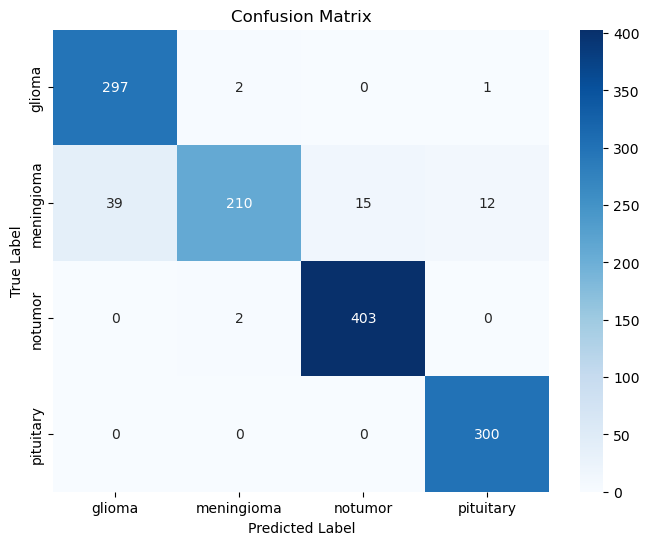

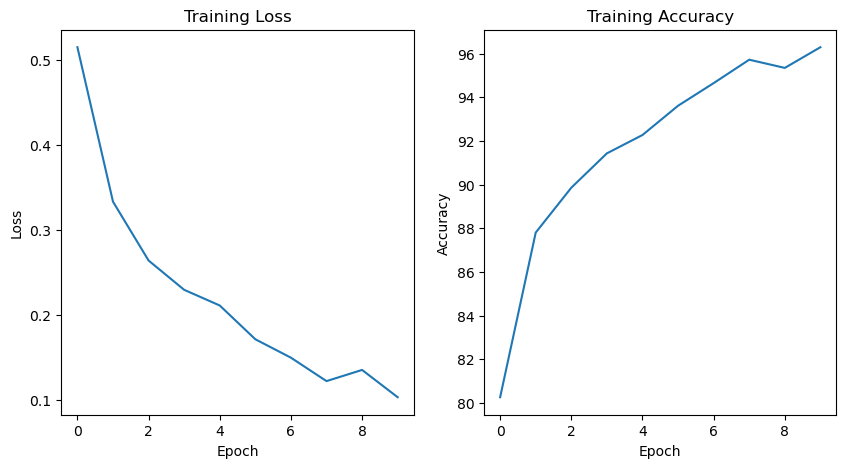

In [6]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)


# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")


# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))


# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):  # Handle jpg and png
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB

        label = self.labels[idx]
        label_idx = self.label_to_index[label]


        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Define transformations
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a consistent size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # Add random rotation for data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
    ]),
    'testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])


# Create DataLoaders
batch_size = 32  #Adjust as necessary

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# 4. Define the Enhanced CNN Model
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.25):
        super(EnhancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjusted input size
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out



# 5. Training Loop and Evaluation (within SageMaker Studio)

def train_and_evaluate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Using Adam optimizer

    # Store training history
    history = {'loss': [], 'accuracy': []}

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):  # Use tqdm for progress bar
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    print("Finished Training.")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1


    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")


    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.label_to_index.keys(), yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


    return class_accuracies, cm, cr, history


# Instantiate the model
model = EnhancedCNN() # Changed to the EnhancedCNN model

# Train and Evaluate
class_accuracies, cm, cr, history = train_and_evaluate(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001)

#Code Version2

Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/ to data/testing/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/ to data/testing/notumor
Downloaded data from s3://sagemaker-studio-010526

Epoch 1/20 [Training]: 100%|██████████| 175/175 [03:55<00:00,  1.35s/it]


Epoch 1/20 Training, Loss: 0.4916, Accuracy: 81.04%


Epoch 1/20 [Validation]: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]


Epoch 1/20 Validation, Loss: 0.4579, Accuracy: 82.36%


Epoch 2/20 [Training]: 100%|██████████| 175/175 [03:47<00:00,  1.30s/it]


Epoch 2/20 Training, Loss: 0.3306, Accuracy: 88.07%


Epoch 2/20 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.58it/s]


Epoch 2/20 Validation, Loss: 0.3669, Accuracy: 85.09%


Epoch 3/20 [Training]: 100%|██████████| 175/175 [03:44<00:00,  1.28s/it]


Epoch 3/20 Training, Loss: 0.2677, Accuracy: 89.65%


Epoch 3/20 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 3/20 Validation, Loss: 0.2657, Accuracy: 89.07%


Epoch 4/20 [Training]: 100%|██████████| 175/175 [03:43<00:00,  1.28s/it]


Epoch 4/20 Training, Loss: 0.2364, Accuracy: 91.58%


Epoch 4/20 [Validation]: 100%|██████████| 41/41 [00:21<00:00,  1.90it/s]


Epoch 4/20 Validation, Loss: 0.2485, Accuracy: 89.62%


Epoch 5/20 [Training]: 100%|██████████| 175/175 [03:47<00:00,  1.30s/it]


Epoch 5/20 Training, Loss: 0.2044, Accuracy: 92.85%


Epoch 5/20 [Validation]: 100%|██████████| 41/41 [00:19<00:00,  2.08it/s]


Epoch 5/20 Validation, Loss: 0.1958, Accuracy: 92.04%


Epoch 6/20 [Training]: 100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


Epoch 6/20 Training, Loss: 0.1841, Accuracy: 93.38%


Epoch 6/20 [Validation]: 100%|██████████| 41/41 [00:18<00:00,  2.27it/s]


Epoch 6/20 Validation, Loss: 0.1554, Accuracy: 93.91%


Epoch 7/20 [Training]: 100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


Epoch 7/20 Training, Loss: 0.1660, Accuracy: 93.62%


Epoch 7/20 [Validation]: 100%|██████████| 41/41 [00:18<00:00,  2.16it/s]


Epoch 7/20 Validation, Loss: 0.4007, Accuracy: 83.45%


Epoch 8/20 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.31s/it]


Epoch 8/20 Training, Loss: 0.1493, Accuracy: 94.78%


Epoch 8/20 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 8/20 Validation, Loss: 0.1519, Accuracy: 94.69%


Epoch 9/20 [Training]: 100%|██████████| 175/175 [03:51<00:00,  1.32s/it]


Epoch 9/20 Training, Loss: 0.1354, Accuracy: 95.26%


Epoch 9/20 [Validation]: 100%|██████████| 41/41 [00:24<00:00,  1.71it/s]


Epoch 9/20 Validation, Loss: 0.1469, Accuracy: 95.16%


Epoch 10/20 [Training]: 100%|██████████| 175/175 [03:46<00:00,  1.30s/it]


Epoch 10/20 Training, Loss: 0.1248, Accuracy: 95.55%


Epoch 10/20 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 10/20 Validation, Loss: 0.1156, Accuracy: 95.86%


Epoch 11/20 [Training]: 100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


Epoch 11/20 Training, Loss: 0.1279, Accuracy: 95.55%


Epoch 11/20 [Validation]: 100%|██████████| 41/41 [00:21<00:00,  1.93it/s]


Epoch 11/20 Validation, Loss: 0.1193, Accuracy: 95.78%


Epoch 12/20 [Training]: 100%|██████████| 175/175 [03:44<00:00,  1.28s/it]


Epoch 12/20 Training, Loss: 0.1168, Accuracy: 95.67%


Epoch 12/20 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 12/20 Validation, Loss: 0.1049, Accuracy: 96.49%


Epoch 13/20 [Training]: 100%|██████████| 175/175 [03:46<00:00,  1.30s/it]


Epoch 13/20 Training, Loss: 0.1121, Accuracy: 96.28%


Epoch 13/20 [Validation]: 100%|██████████| 41/41 [00:21<00:00,  1.91it/s]


Epoch 13/20 Validation, Loss: 0.1135, Accuracy: 95.71%


Epoch 14/20 [Training]: 100%|██████████| 175/175 [03:47<00:00,  1.30s/it]


Epoch 14/20 Training, Loss: 0.1021, Accuracy: 96.35%


Epoch 14/20 [Validation]: 100%|██████████| 41/41 [00:25<00:00,  1.59it/s]


Epoch 14/20 Validation, Loss: 0.1892, Accuracy: 91.65%


Epoch 15/20 [Training]: 100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


Epoch 15/20 Training, Loss: 0.0915, Accuracy: 96.76%


Epoch 15/20 [Validation]: 100%|██████████| 41/41 [00:17<00:00,  2.28it/s]


Epoch 15/20 Validation, Loss: 0.3496, Accuracy: 87.43%


Epoch 16/20 [Training]: 100%|██████████| 175/175 [03:47<00:00,  1.30s/it]


Epoch 16/20 Training, Loss: 0.0971, Accuracy: 96.60%


Epoch 16/20 [Validation]: 100%|██████████| 41/41 [00:25<00:00,  1.58it/s]


Epoch 16/20 Validation, Loss: 0.1228, Accuracy: 94.77%


Epoch 17/20 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.31s/it]


Epoch 17/20 Training, Loss: 0.0983, Accuracy: 96.80%


Epoch 17/20 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 17/20 Validation, Loss: 0.1032, Accuracy: 96.64%


Epoch 18/20 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.30s/it]


Epoch 18/20 Training, Loss: 0.0802, Accuracy: 97.30%


Epoch 18/20 [Validation]: 100%|██████████| 41/41 [00:25<00:00,  1.58it/s]


Epoch 18/20 Validation, Loss: 0.0774, Accuracy: 97.50%


Epoch 19/20 [Training]: 100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


Epoch 19/20 Training, Loss: 0.0707, Accuracy: 97.41%


Epoch 19/20 [Validation]: 100%|██████████| 41/41 [00:19<00:00,  2.12it/s]


Epoch 19/20 Validation, Loss: 0.0845, Accuracy: 97.27%


Epoch 20/20 [Training]: 100%|██████████| 175/175 [03:46<00:00,  1.29s/it]


Epoch 20/20 Training, Loss: 0.0833, Accuracy: 96.80%


Epoch 20/20 [Validation]: 100%|██████████| 41/41 [00:25<00:00,  1.58it/s]


Epoch 20/20 Validation, Loss: 0.0945, Accuracy: 96.80%
Finished Training.


100%|██████████| 41/41 [00:26<00:00,  1.58it/s]


Accuracy for glioma: 0.9433
Accuracy for meningioma: 0.9130
Accuracy for notumor: 1.0000
Accuracy for pituitary: 1.0000

Confusion Matrix:
[[283  15   0   2]
 [  3 252  10  11]
 [  0   0 405   0]
 [  0   0   0 300]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.94      0.97       300
  meningioma       0.94      0.91      0.93       276
     notumor       0.98      1.00      0.99       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.97      1281
   macro avg       0.97      0.96      0.97      1281
weighted avg       0.97      0.97      0.97      1281



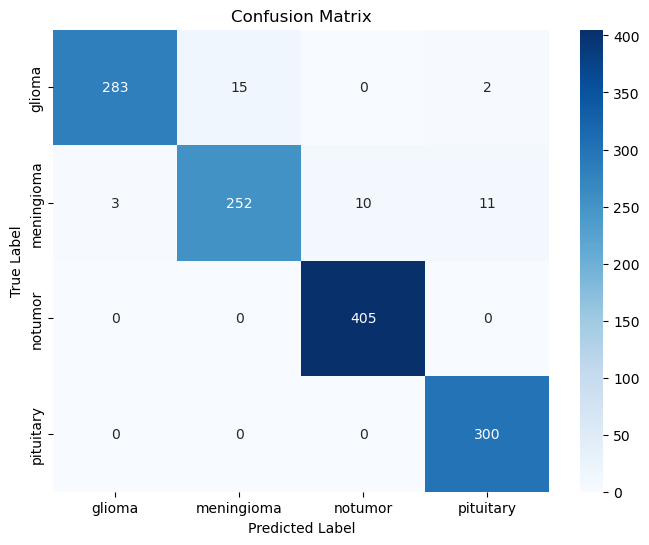

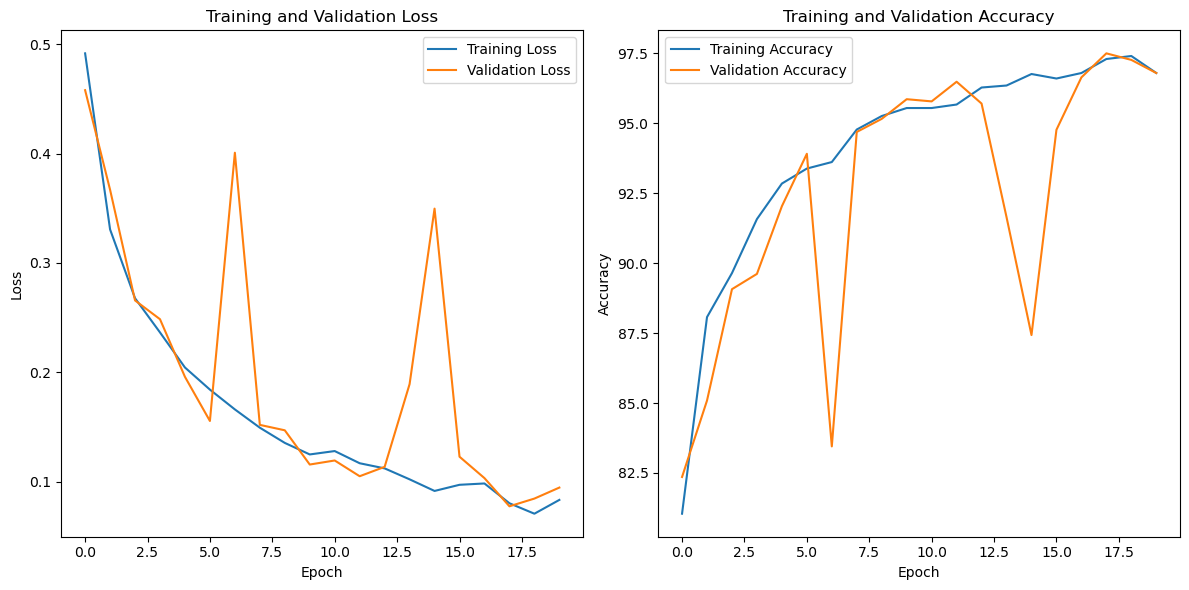

In [7]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)


# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")


# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))


# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):  # Handle jpg and png
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB

        label = self.labels[idx]
        label_idx = self.label_to_index[label]


        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Define transformations
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a consistent size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # Add random rotation for data augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
    ]),
    'testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])


# Create DataLoaders
batch_size = 32  #Adjust as necessary

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# 4. Define the Enhanced CNN Model
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.4):  # Increased dropout rate
        super(EnhancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(  # Added a 4th convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # Adjusted input size after layer4
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out



# 5. Training Loop and Evaluation (within SageMaker Studio)

def train_and_evaluate(model, train_loader, test_loader, num_epochs=20, learning_rate=0.0005, weight_decay=1e-4): # Increased epochs, reduced learning rate, added weight decay
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Using Adam optimizer

    # Store training history
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []} # Added validation metrics

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):  # Use tqdm for progress bar
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Training, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(test_loader)
        epoch_val_accuracy = 100 * val_correct / val_total

        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Validation, Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")


    print("Finished Training.")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1


    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")


    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.label_to_index.keys(), yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout() #Adjusts plot parameters for a tight layout
    plt.show()


    return class_accuracies, cm, cr, history


# Instantiate the model
model = EnhancedCNN() # Changed to the EnhancedCNN model

# Train and Evaluate
class_accuracies, cm, cr, history = train_and_evaluate(model, train_loader, test_loader, num_epochs=20, learning_rate=0.0005)

#Code Version3

Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/ to data/testing/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/ to data/testing/notumor
Downloaded data from s3://sagemaker-studio-010526

Epoch 1/30 [Training]: 100%|██████████| 175/175 [03:45<00:00,  1.29s/it]


Epoch 1/30 Training, Loss: 0.6744, Accuracy: 72.76%


Epoch 1/30 [Validation]: 100%|██████████| 41/41 [00:17<00:00,  2.32it/s]


Epoch 1/30 Validation, Loss: 0.5083, Accuracy: 77.83%


Epoch 2/30 [Training]: 100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 2/30 Training, Loss: 0.4674, Accuracy: 82.60%


Epoch 2/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 2/30 Validation, Loss: 0.6424, Accuracy: 73.77%


Epoch 3/30 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.31s/it]


Epoch 3/30 Training, Loss: 0.4138, Accuracy: 84.92%


Epoch 3/30 [Validation]: 100%|██████████| 41/41 [00:24<00:00,  1.67it/s]


Epoch 3/30 Validation, Loss: 0.4908, Accuracy: 80.95%


Epoch 4/30 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.30s/it]


Epoch 4/30 Training, Loss: 0.3590, Accuracy: 86.71%


Epoch 4/30 [Validation]: 100%|██████████| 41/41 [00:18<00:00,  2.25it/s]


Epoch 4/30 Validation, Loss: 0.3455, Accuracy: 85.25%


Epoch 5/30 [Training]: 100%|██████████| 175/175 [03:54<00:00,  1.34s/it]


Epoch 5/30 Training, Loss: 0.3566, Accuracy: 86.39%


Epoch 5/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 5/30 Validation, Loss: 0.5110, Accuracy: 81.42%


Epoch 6/30 [Training]: 100%|██████████| 175/175 [03:49<00:00,  1.31s/it]


Epoch 6/30 Training, Loss: 0.3196, Accuracy: 87.89%


Epoch 6/30 [Validation]: 100%|██████████| 41/41 [00:24<00:00,  1.67it/s]


Epoch 6/30 Validation, Loss: 0.5294, Accuracy: 82.98%


Epoch 7/30 [Training]: 100%|██████████| 175/175 [03:46<00:00,  1.29s/it]


Epoch 7/30 Training, Loss: 0.2947, Accuracy: 89.13%


Epoch 7/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 7/30 Validation, Loss: 0.2551, Accuracy: 90.16%


Epoch 8/30 [Training]: 100%|██████████| 175/175 [03:51<00:00,  1.32s/it]


Epoch 8/30 Training, Loss: 0.2966, Accuracy: 89.06%


Epoch 8/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 8/30 Validation, Loss: 0.2507, Accuracy: 90.09%


Epoch 9/30 [Training]: 100%|██████████| 175/175 [03:50<00:00,  1.32s/it]


Epoch 9/30 Training, Loss: 0.2929, Accuracy: 89.34%


Epoch 9/30 [Validation]: 100%|██████████| 41/41 [00:24<00:00,  1.65it/s]


Epoch 9/30 Validation, Loss: 0.2825, Accuracy: 88.99%


Epoch 10/30 [Training]: 100%|██████████| 175/175 [03:51<00:00,  1.32s/it]


Epoch 10/30 Training, Loss: 0.2683, Accuracy: 90.40%


Epoch 10/30 [Validation]: 100%|██████████| 41/41 [00:25<00:00,  1.59it/s]


Epoch 10/30 Validation, Loss: 0.3118, Accuracy: 86.73%


Epoch 11/30 [Training]: 100%|██████████| 175/175 [03:56<00:00,  1.35s/it]


Epoch 11/30 Training, Loss: 0.2687, Accuracy: 89.82%


Epoch 11/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 11/30 Validation, Loss: 0.2631, Accuracy: 88.84%
Epoch 00011: reducing learning rate of group 0 to 3.0000e-05.


Epoch 12/30 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.31s/it]


Epoch 12/30 Training, Loss: 0.2114, Accuracy: 92.40%


Epoch 12/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 12/30 Validation, Loss: 0.1846, Accuracy: 92.12%


Epoch 13/30 [Training]: 100%|██████████| 175/175 [03:49<00:00,  1.31s/it]


Epoch 13/30 Training, Loss: 0.2036, Accuracy: 92.94%


Epoch 13/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 13/30 Validation, Loss: 0.1806, Accuracy: 91.88%


Epoch 14/30 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.31s/it]


Epoch 14/30 Training, Loss: 0.1952, Accuracy: 92.86%


Epoch 14/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 14/30 Validation, Loss: 0.1643, Accuracy: 93.13%


Epoch 15/30 [Training]: 100%|██████████| 175/175 [03:48<00:00,  1.30s/it]


Epoch 15/30 Training, Loss: 0.1994, Accuracy: 92.31%


Epoch 15/30 [Validation]: 100%|██████████| 41/41 [00:18<00:00,  2.20it/s]


Epoch 15/30 Validation, Loss: 0.1651, Accuracy: 93.21%


Epoch 16/30 [Training]: 100%|██████████| 175/175 [03:49<00:00,  1.31s/it]


Epoch 16/30 Training, Loss: 0.1900, Accuracy: 93.15%


Epoch 16/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 16/30 Validation, Loss: 0.1549, Accuracy: 93.21%


Epoch 17/30 [Training]: 100%|██████████| 175/175 [03:50<00:00,  1.32s/it]


Epoch 17/30 Training, Loss: 0.1841, Accuracy: 93.01%


Epoch 17/30 [Validation]: 100%|██████████| 41/41 [00:17<00:00,  2.32it/s]


Epoch 17/30 Validation, Loss: 0.1620, Accuracy: 92.74%


Epoch 18/30 [Training]: 100%|██████████| 175/175 [03:50<00:00,  1.32s/it]


Epoch 18/30 Training, Loss: 0.1806, Accuracy: 93.45%


Epoch 18/30 [Validation]: 100%|██████████| 41/41 [00:18<00:00,  2.24it/s]


Epoch 18/30 Validation, Loss: 0.1394, Accuracy: 93.75%


Epoch 19/30 [Training]: 100%|██████████| 175/175 [03:52<00:00,  1.33s/it]


Epoch 19/30 Training, Loss: 0.1694, Accuracy: 93.94%


Epoch 19/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 19/30 Validation, Loss: 0.1702, Accuracy: 92.43%


Epoch 20/30 [Training]: 100%|██████████| 175/175 [03:51<00:00,  1.32s/it]


Epoch 20/30 Training, Loss: 0.1762, Accuracy: 94.12%


Epoch 20/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 20/30 Validation, Loss: 0.1469, Accuracy: 93.68%


Epoch 21/30 [Training]: 100%|██████████| 175/175 [03:52<00:00,  1.33s/it]


Epoch 21/30 Training, Loss: 0.1714, Accuracy: 93.71%


Epoch 21/30 [Validation]: 100%|██████████| 41/41 [00:25<00:00,  1.62it/s]


Epoch 21/30 Validation, Loss: 0.1414, Accuracy: 93.52%
Epoch 00021: reducing learning rate of group 0 to 3.0000e-06.


Epoch 22/30 [Training]: 100%|██████████| 175/175 [03:50<00:00,  1.32s/it]


Epoch 22/30 Training, Loss: 0.1697, Accuracy: 94.24%


Epoch 22/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


Epoch 22/30 Validation, Loss: 0.1342, Accuracy: 94.15%


Epoch 23/30 [Training]: 100%|██████████| 175/175 [03:51<00:00,  1.32s/it]


Epoch 23/30 Training, Loss: 0.1587, Accuracy: 94.37%


Epoch 23/30 [Validation]: 100%|██████████| 41/41 [00:18<00:00,  2.22it/s]


Epoch 23/30 Validation, Loss: 0.1304, Accuracy: 93.99%


Epoch 24/30 [Training]: 100%|██████████| 175/175 [03:50<00:00,  1.31s/it]


Epoch 24/30 Training, Loss: 0.1657, Accuracy: 93.87%


Epoch 24/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 24/30 Validation, Loss: 0.1396, Accuracy: 93.29%


Epoch 25/30 [Training]: 100%|██████████| 175/175 [03:52<00:00,  1.33s/it]


Epoch 25/30 Training, Loss: 0.1553, Accuracy: 94.58%


Epoch 25/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 25/30 Validation, Loss: 0.1361, Accuracy: 93.83%


Epoch 26/30 [Training]: 100%|██████████| 175/175 [03:52<00:00,  1.33s/it]


Epoch 26/30 Training, Loss: 0.1664, Accuracy: 93.81%


Epoch 26/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.55it/s]


Epoch 26/30 Validation, Loss: 0.1315, Accuracy: 93.91%
Epoch 00026: reducing learning rate of group 0 to 3.0000e-07.


Epoch 27/30 [Training]: 100%|██████████| 175/175 [03:51<00:00,  1.32s/it]


Epoch 27/30 Training, Loss: 0.1668, Accuracy: 93.67%


Epoch 27/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 27/30 Validation, Loss: 0.1390, Accuracy: 93.91%


Epoch 28/30 [Training]: 100%|██████████| 175/175 [03:49<00:00,  1.31s/it]


Epoch 28/30 Training, Loss: 0.1714, Accuracy: 93.74%


Epoch 28/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Epoch 28/30 Validation, Loss: 0.1274, Accuracy: 94.38%


Epoch 29/30 [Training]: 100%|██████████| 175/175 [03:53<00:00,  1.33s/it]


Epoch 29/30 Training, Loss: 0.1556, Accuracy: 94.40%


Epoch 29/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.56it/s]


Epoch 29/30 Validation, Loss: 0.1388, Accuracy: 93.91%


Epoch 30/30 [Training]: 100%|██████████| 175/175 [03:50<00:00,  1.32s/it]


Epoch 30/30 Training, Loss: 0.1532, Accuracy: 94.22%


Epoch 30/30 [Validation]: 100%|██████████| 41/41 [00:26<00:00,  1.55it/s]


Epoch 30/30 Validation, Loss: 0.1276, Accuracy: 94.30%
Finished Training.


100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Accuracy for glioma: 0.8867
Accuracy for meningioma: 0.8913
Accuracy for notumor: 0.9901
Accuracy for pituitary: 0.9833

Confusion Matrix:
[[266  32   0   2]
 [  1 246  17  12]
 [  3   1 401   0]
 [  0   5   0 295]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.89      0.93       300
  meningioma       0.87      0.89      0.88       276
     notumor       0.96      0.99      0.97       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.94      1281
   macro avg       0.94      0.94      0.94      1281
weighted avg       0.94      0.94      0.94      1281



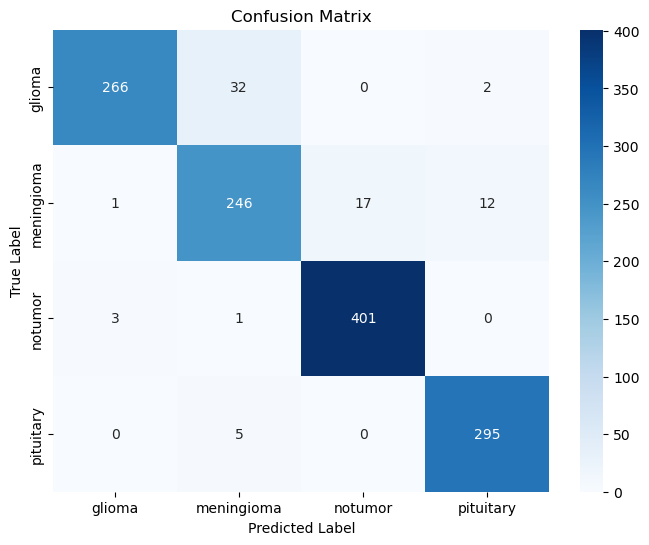

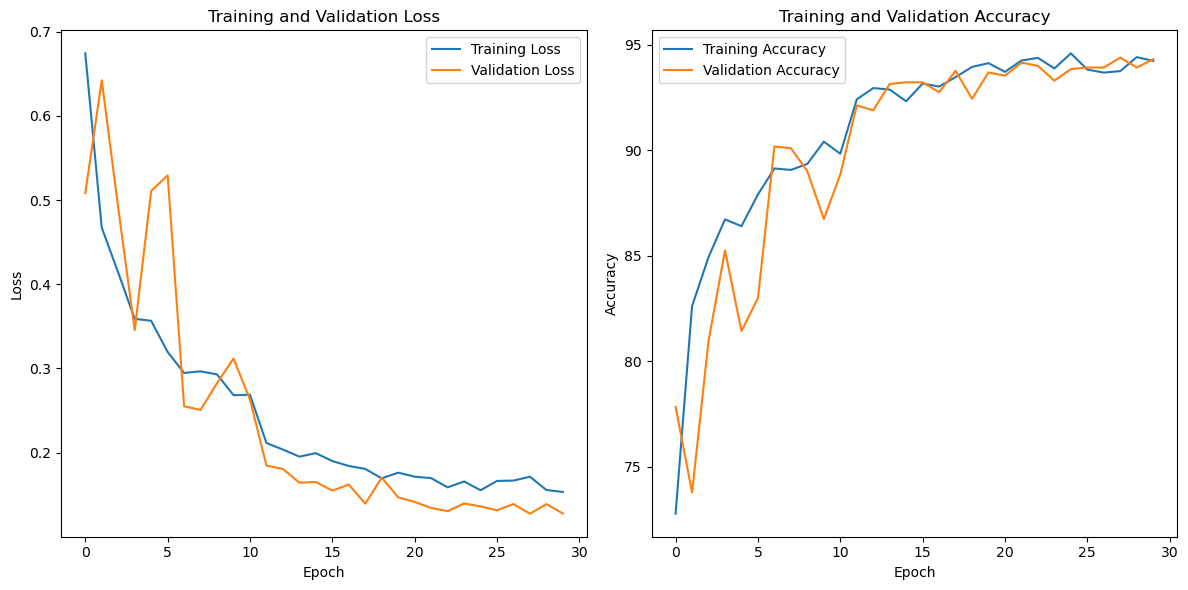

In [8]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)


# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")


# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))


# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):  # Handle jpg and png
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB

        label = self.labels[idx]
        label_idx = self.label_to_index[label]


        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Define transformations
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a consistent size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # Add random rotation for data augmentation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), #Add random translation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Add random color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
    ]),
    'testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])


# Create DataLoaders
batch_size = 32  #Adjust as necessary

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


# 4. Define the Enhanced CNN Model
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.4):  # Increased dropout rate
        super(EnhancedCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(  # Added a 4th convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # Adjusted input size after layer4
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) # Flatten
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out



# 5. Training Loop and Evaluation (within SageMaker Studio)

def train_and_evaluate(model, train_loader, test_loader, num_epochs=30, learning_rate=0.0003, weight_decay=1e-4, patience=5): # Increased epochs, reduced learning rate, added weight decay
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Using Adam optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Store training history
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []} # Added validation metrics

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):  # Use tqdm for progress bar
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Training, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(test_loader)
        epoch_val_accuracy = 100 * val_correct / val_total

        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Validation, Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")

        scheduler.step(epoch_val_loss)

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break


    print("Finished Training.")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1


    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")


    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.label_to_index.keys(), yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout() #Adjusts plot parameters for a tight layout
    plt.show()


    return class_accuracies, cm, cr, history


# Instantiate the model
model = EnhancedCNN() # Changed to the EnhancedCNN model

# Train and Evaluate
class_accuracies, cm, cr, history = train_and_evaluate(model, train_loader, test_loader, num_epochs=30, learning_rate=0.0003)

#Code Version4

Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/ to data/testing/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/ to data/testing/notumor
Downloaded data from s3://sagemaker-studio-010526

Epoch 1/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 1/40 Training, Loss: 0.5265, Accuracy: 56.04%
Epoch 1/40 Validation, Loss: 0.6055, Accuracy: 46.68%


Epoch 2/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Epoch 2/40 Training, Loss: 0.4149, Accuracy: 63.07%
Epoch 2/40 Validation, Loss: 0.3692, Accuracy: 64.40%


Epoch 3/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Epoch 3/40 Training, Loss: 0.3332, Accuracy: 69.10%
Epoch 3/40 Validation, Loss: 0.3225, Accuracy: 69.16%


Epoch 4/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 4/40 Training, Loss: 0.2709, Accuracy: 75.84%
Epoch 4/40 Validation, Loss: 0.3723, Accuracy: 68.46%


Epoch 5/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Epoch 5/40 Training, Loss: 0.2216, Accuracy: 79.36%
Epoch 5/40 Validation, Loss: 0.2102, Accuracy: 77.44%


Epoch 6/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Epoch 6/40 Training, Loss: 0.3027, Accuracy: 72.60%
Epoch 6/40 Validation, Loss: 0.2697, Accuracy: 77.28%


Epoch 7/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Epoch 7/40 Training, Loss: 0.2588, Accuracy: 75.88%
Epoch 7/40 Validation, Loss: 0.2164, Accuracy: 79.08%


Epoch 8/40 [Validation]: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Epoch 8/40 Training, Loss: 0.2095, Accuracy: 79.90%
Epoch 8/40 Validation, Loss: 0.6994, Accuracy: 57.46%


Epoch 9/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.63it/s]


Epoch 9/40 Training, Loss: 0.1970, Accuracy: 81.40%
Epoch 9/40 Validation, Loss: 0.1827, Accuracy: 78.45%


Epoch 10/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.62it/s]


Epoch 10/40 Training, Loss: 0.1774, Accuracy: 82.69%
Epoch 10/40 Validation, Loss: 0.1796, Accuracy: 82.51%


Epoch 11/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.62it/s]


Epoch 11/40 Training, Loss: 0.1531, Accuracy: 85.43%
Epoch 11/40 Validation, Loss: 0.1481, Accuracy: 84.54%


Epoch 12/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.62it/s]


Epoch 12/40 Training, Loss: 0.1325, Accuracy: 86.41%
Epoch 12/40 Validation, Loss: 0.1430, Accuracy: 84.78%


Epoch 13/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Epoch 13/40 Training, Loss: 0.1212, Accuracy: 88.00%
Epoch 13/40 Validation, Loss: 0.1039, Accuracy: 88.68%


Epoch 14/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 14/40 Training, Loss: 0.1070, Accuracy: 88.98%
Epoch 14/40 Validation, Loss: 0.0875, Accuracy: 89.70%


Epoch 15/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.62it/s]


Epoch 15/40 Training, Loss: 0.1049, Accuracy: 89.20%
Epoch 15/40 Validation, Loss: 0.0878, Accuracy: 89.85%


Epoch 16/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 16/40 Training, Loss: 0.1713, Accuracy: 83.69%
Epoch 16/40 Validation, Loss: 0.1337, Accuracy: 85.17%


Epoch 17/40 [Validation]: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Epoch 17/40 Training, Loss: 0.1533, Accuracy: 85.89%
Epoch 17/40 Validation, Loss: 0.1044, Accuracy: 88.60%


Epoch 18/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Epoch 18/40 Training, Loss: 0.1329, Accuracy: 86.21%
Epoch 18/40 Validation, Loss: 0.1570, Accuracy: 81.81%


Epoch 19/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Epoch 19/40 Training, Loss: 0.1259, Accuracy: 87.64%
Epoch 19/40 Validation, Loss: 0.2930, Accuracy: 75.72%


Epoch 20/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Epoch 20/40 Training, Loss: 0.1225, Accuracy: 88.50%
Epoch 20/40 Validation, Loss: 0.1501, Accuracy: 84.07%


Epoch 21/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.53it/s]


Epoch 21/40 Training, Loss: 0.0968, Accuracy: 90.43%
Epoch 21/40 Validation, Loss: 0.0735, Accuracy: 91.80%


Epoch 22/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.59it/s]


Epoch 22/40 Training, Loss: 0.0948, Accuracy: 90.63%
Epoch 22/40 Validation, Loss: 0.0723, Accuracy: 91.57%


Epoch 23/40 [Validation]: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Epoch 23/40 Training, Loss: 0.0857, Accuracy: 91.36%
Epoch 23/40 Validation, Loss: 0.0986, Accuracy: 88.84%


Epoch 24/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.59it/s]


Epoch 24/40 Training, Loss: 0.0956, Accuracy: 90.59%
Epoch 24/40 Validation, Loss: 0.0617, Accuracy: 92.82%


Epoch 25/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 25/40 Training, Loss: 0.0724, Accuracy: 92.17%
Epoch 25/40 Validation, Loss: 0.0529, Accuracy: 95.00%


Epoch 26/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Epoch 26/40 Training, Loss: 0.0702, Accuracy: 93.20%
Epoch 26/40 Validation, Loss: 0.1150, Accuracy: 89.07%


Epoch 27/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 27/40 Training, Loss: 0.0748, Accuracy: 92.19%
Epoch 27/40 Validation, Loss: 0.0605, Accuracy: 93.75%


Epoch 28/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Epoch 28/40 Training, Loss: 0.0602, Accuracy: 93.53%
Epoch 28/40 Validation, Loss: 0.0438, Accuracy: 95.00%


Epoch 29/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.56it/s]


Epoch 29/40 Training, Loss: 0.0622, Accuracy: 93.62%
Epoch 29/40 Validation, Loss: 0.0485, Accuracy: 93.91%


Epoch 30/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]


Epoch 30/40 Training, Loss: 0.0516, Accuracy: 94.71%
Epoch 30/40 Validation, Loss: 0.0362, Accuracy: 96.41%


Epoch 31/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Epoch 31/40 Training, Loss: 0.0535, Accuracy: 94.92%
Epoch 31/40 Validation, Loss: 0.0376, Accuracy: 95.86%


Epoch 32/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 32/40 Training, Loss: 0.0482, Accuracy: 94.89%
Epoch 32/40 Validation, Loss: 0.0347, Accuracy: 96.02%


Epoch 33/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Epoch 33/40 Training, Loss: 0.0493, Accuracy: 95.03%
Epoch 33/40 Validation, Loss: 0.0356, Accuracy: 96.25%


Epoch 34/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 34/40 Training, Loss: 0.0478, Accuracy: 95.05%
Epoch 34/40 Validation, Loss: 0.0336, Accuracy: 96.10%


Epoch 35/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.55it/s]


Epoch 35/40 Training, Loss: 0.0477, Accuracy: 94.94%
Epoch 35/40 Validation, Loss: 0.0350, Accuracy: 95.63%


Epoch 36/40 [Validation]: 100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


Epoch 36/40 Training, Loss: 0.1061, Accuracy: 89.59%
Epoch 36/40 Validation, Loss: 0.1406, Accuracy: 89.31%


Epoch 37/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.62it/s]


Epoch 37/40 Training, Loss: 0.0868, Accuracy: 90.86%
Epoch 37/40 Validation, Loss: 0.1275, Accuracy: 86.81%


Epoch 38/40 [Validation]: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]


Epoch 38/40 Training, Loss: 0.0847, Accuracy: 91.18%
Epoch 38/40 Validation, Loss: 0.0764, Accuracy: 93.21%


Epoch 39/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.54it/s]


Epoch 39/40 Training, Loss: 0.0748, Accuracy: 92.17%
Epoch 39/40 Validation, Loss: 0.0616, Accuracy: 93.21%


Epoch 40/40 [Validation]: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]


Epoch 40/40 Training, Loss: 0.0761, Accuracy: 91.85%
Epoch 40/40 Validation, Loss: 0.0407, Accuracy: 96.10%


100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


Accuracy for glioma: 0.9433
Accuracy for meningioma: 0.9130
Accuracy for notumor: 0.9926
Accuracy for pituitary: 0.9800

Confusion Matrix:
[[283  17   0   0]
 [  5 252  14   5]
 [  3   0 402   0]
 [  0   6   0 294]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.94      0.96       300
  meningioma       0.92      0.91      0.91       276
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.96      1281
   macro avg       0.96      0.96      0.96      1281
weighted avg       0.96      0.96      0.96      1281



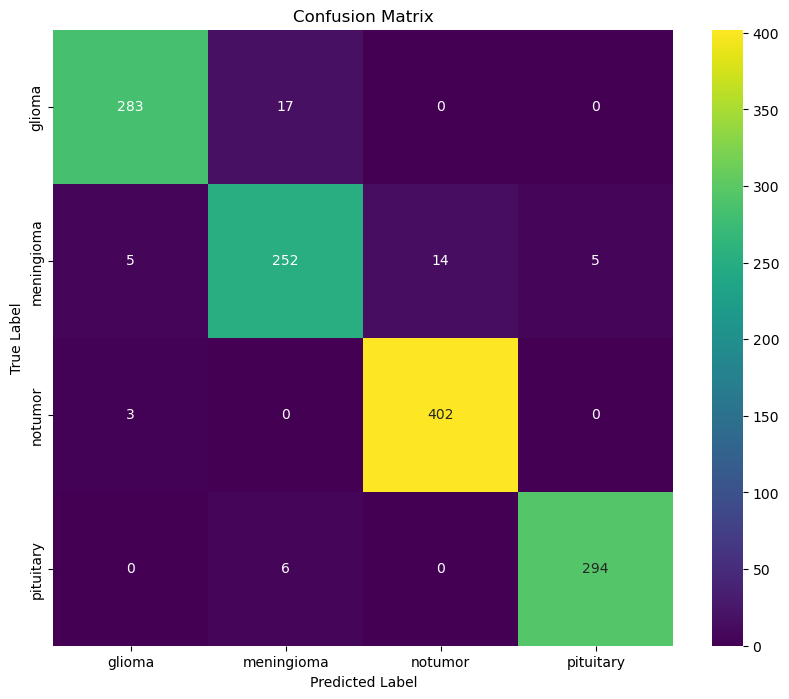

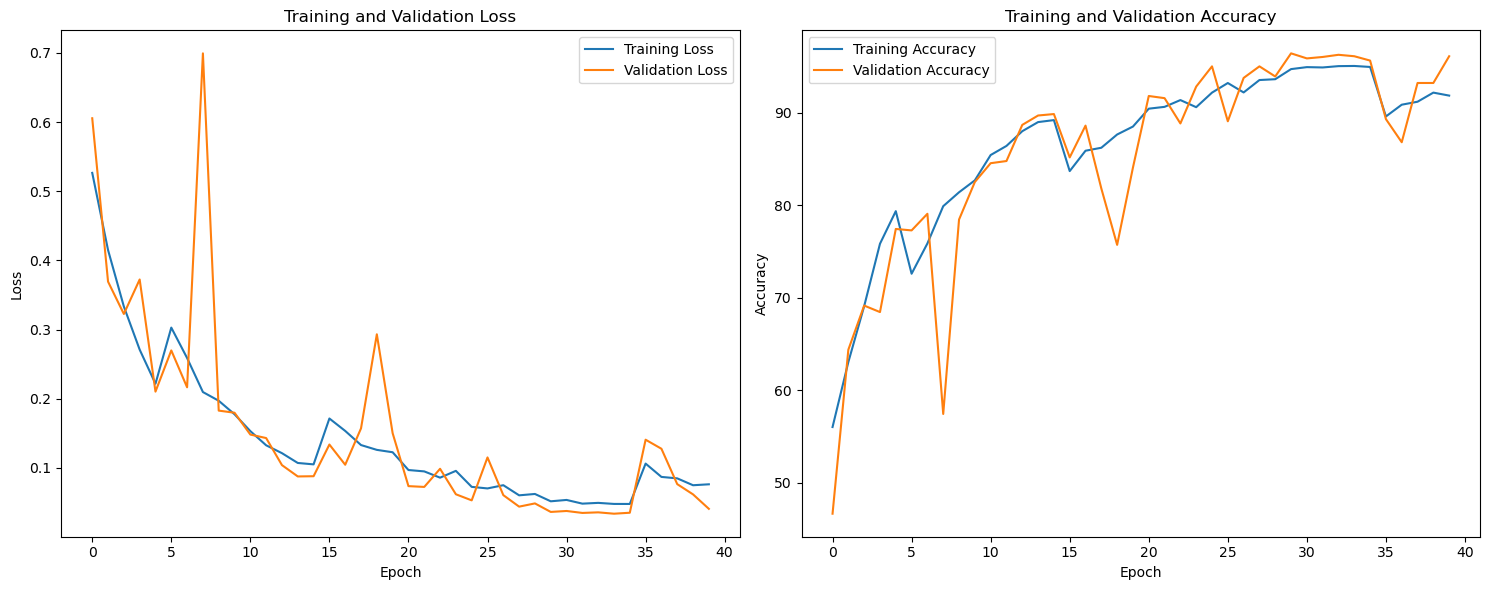

In [9]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)

# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")

# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))

# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        label_idx = self.label_to_index[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Define advanced transformations with more augmentation
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])

# Create DataLoaders with balanced sampling
from torch.utils.data import WeightedRandomSampler

def get_class_weights(dataset):
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    total_samples = len(dataset)
    class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
    
    weights = [class_weights[label] for _, label in dataset]
    return weights

batch_size = 48  # Increased batch size
num_workers = 8  # Increased workers

train_weights = get_class_weights(train_dataset)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, pin_memory=True)

# 4. Define an Advanced CNN Model with Residual Connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += self.shortcut(residual)
        return nn.functional.relu(out)

class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(AdvancedCNN, self).__init__()
        
        self.in_channels = 64
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# 5. Training Loop and Evaluation
def train_and_evaluate(model, train_loader, test_loader, num_epochs=40, learning_rate=1e-3, 
                       weight_decay=1e-4, patience=7, label_smoothing=0.1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Use Focal Loss for handling class imbalance
    class FocalLoss(nn.Module):
        def __init__(self, alpha=1, gamma=2, reduction='mean'):
            super(FocalLoss, self).__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.reduction = reduction

        def forward(self, inputs, targets):
            ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
            pt = torch.exp(-ce_loss)
            focal_loss = (self.alpha * (1-pt)**self.gamma * ce_loss).mean()
            return focal_loss

    criterion = FocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay, amsgrad=True)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step(epoch + epoch / num_epochs)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)

        # Validation 
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(test_loader)
        epoch_val_accuracy = 100 * val_correct / val_total

        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} Training, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation, Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")

        # Early stopping 
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break

    # Evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds, all_labels = [], []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1

    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
                xticklabels=train_dataset.label_to_index.keys(), 
                yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return class_accuracies, cm, cr, history

# Instantiate the model
model = AdvancedCNN()

# Train and Evaluate
class_accuracies, cm, cr, history = train_and_evaluate(model, train_loader, test_loader)

#Code Version5

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningiom

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Starting Training...


Epoch 1/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 1/50 Training, Loss: 1.1842, Accuracy: 50.25%
Epoch 1/50 Validation, Loss: 1.3138, Accuracy: 42.54%


Epoch 2/50 [Validation]: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 2/50 Training, Loss: 1.0573, Accuracy: 58.85%
Epoch 2/50 Validation, Loss: 1.2483, Accuracy: 46.99%


Epoch 7/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 7/50 Training, Loss: 0.7854, Accuracy: 77.90%
Epoch 7/50 Validation, Loss: 0.8237, Accuracy: 77.05%


Epoch 8/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 8/50 Training, Loss: 0.7016, Accuracy: 81.99%
Epoch 8/50 Validation, Loss: 0.9468, Accuracy: 70.88%


Epoch 9/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 9/50 Training, Loss: 0.6672, Accuracy: 84.25%
Epoch 9/50 Validation, Loss: 0.8774, Accuracy: 73.30%


Epoch 10/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 10/50 Training, Loss: 0.6252, Accuracy: 86.11%
Epoch 10/50 Validation, Loss: 0.8139, Accuracy: 78.06%


Epoch 11/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 11/50 Training, Loss: 0.6097, Accuracy: 87.14%
Epoch 11/50 Validation, Loss: 0.6102, Accuracy: 86.65%


Epoch 12/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


Epoch 12/50 Training, Loss: 0.5710, Accuracy: 88.81%
Epoch 12/50 Validation, Loss: 0.6912, Accuracy: 83.61%


Epoch 13/50 [Validation]: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch 13/50 Training, Loss: 0.5524, Accuracy: 90.33%
Epoch 13/50 Validation, Loss: 0.6077, Accuracy: 87.74%


Epoch 14/50 [Validation]: 100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


Epoch 14/50 Training, Loss: 0.5346, Accuracy: 91.42%
Epoch 14/50 Validation, Loss: 0.5987, Accuracy: 87.59%


Epoch 15/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 15/50 Training, Loss: 0.5280, Accuracy: 91.52%
Epoch 15/50 Validation, Loss: 0.6081, Accuracy: 87.43%


Epoch 16/50 [Validation]: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 16/50 Training, Loss: 0.6147, Accuracy: 86.77%
Epoch 16/50 Validation, Loss: 0.9939, Accuracy: 69.71%


Epoch 17/50 [Validation]: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 17/50 Training, Loss: 0.6018, Accuracy: 87.59%
Epoch 17/50 Validation, Loss: 0.7662, Accuracy: 81.89%


Epoch 18/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 18/50 Training, Loss: 0.5888, Accuracy: 88.63%
Epoch 18/50 Validation, Loss: 0.7458, Accuracy: 80.56%


Epoch 19/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


Epoch 19/50 Training, Loss: 0.5770, Accuracy: 88.95%
Epoch 19/50 Validation, Loss: 0.6665, Accuracy: 83.68%


Epoch 20/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


Epoch 20/50 Training, Loss: 0.5530, Accuracy: 90.54%
Epoch 20/50 Validation, Loss: 0.7203, Accuracy: 81.42%


Epoch 21/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 21/50 Training, Loss: 0.5541, Accuracy: 90.56%
Epoch 21/50 Validation, Loss: 0.5967, Accuracy: 87.20%


Epoch 22/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 22/50 Training, Loss: 0.5388, Accuracy: 91.04%
Epoch 22/50 Validation, Loss: 0.6710, Accuracy: 83.68%


Epoch 23/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 23/50 Training, Loss: 0.5195, Accuracy: 92.08%
Epoch 23/50 Validation, Loss: 0.5637, Accuracy: 88.84%


Epoch 24/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 24/50 Training, Loss: 0.5113, Accuracy: 92.06%
Epoch 24/50 Validation, Loss: 0.6902, Accuracy: 83.53%


Epoch 25/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 25/50 Training, Loss: 0.5083, Accuracy: 92.45%
Epoch 25/50 Validation, Loss: 0.5462, Accuracy: 89.38%


Epoch 26/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 26/50 Training, Loss: 0.4892, Accuracy: 93.51%
Epoch 26/50 Validation, Loss: 0.5514, Accuracy: 89.70%


Epoch 27/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 27/50 Training, Loss: 0.4757, Accuracy: 94.49%
Epoch 27/50 Validation, Loss: 0.5524, Accuracy: 89.23%


Epoch 28/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 28/50 Training, Loss: 0.4682, Accuracy: 94.99%
Epoch 28/50 Validation, Loss: 0.4659, Accuracy: 94.38%


Epoch 29/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 29/50 Training, Loss: 0.4664, Accuracy: 94.74%
Epoch 29/50 Validation, Loss: 0.5557, Accuracy: 88.84%


Epoch 30/50 [Validation]: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 30/50 Training, Loss: 0.4492, Accuracy: 95.69%
Epoch 30/50 Validation, Loss: 0.4480, Accuracy: 95.32%


Epoch 31/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 31/50 Training, Loss: 0.4440, Accuracy: 96.03%
Epoch 31/50 Validation, Loss: 0.4565, Accuracy: 94.69%


Epoch 32/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.03it/s]


Epoch 32/50 Training, Loss: 0.4467, Accuracy: 95.94%
Epoch 32/50 Validation, Loss: 0.4783, Accuracy: 93.21%


Epoch 33/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 33/50 Training, Loss: 0.4270, Accuracy: 96.91%
Epoch 33/50 Validation, Loss: 0.4689, Accuracy: 93.91%


Epoch 34/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 34/50 Training, Loss: 0.4340, Accuracy: 96.42%
Epoch 34/50 Validation, Loss: 0.4697, Accuracy: 93.60%


Epoch 35/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 35/50 Training, Loss: 0.4343, Accuracy: 96.35%
Epoch 35/50 Validation, Loss: 0.4635, Accuracy: 93.91%


Epoch 36/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 36/50 Training, Loss: 0.5020, Accuracy: 93.01%
Epoch 36/50 Validation, Loss: 0.6770, Accuracy: 83.06%


Epoch 37/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 37/50 Training, Loss: 0.5026, Accuracy: 93.20%
Epoch 37/50 Validation, Loss: 0.7761, Accuracy: 77.75%


Epoch 38/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.02it/s]


Epoch 38/50 Training, Loss: 0.4986, Accuracy: 93.33%
Epoch 38/50 Validation, Loss: 0.7330, Accuracy: 82.59%


Epoch 39/50 [Validation]: 100%|██████████| 27/27 [00:26<00:00,  1.01it/s]


Epoch 39/50 Training, Loss: 0.4952, Accuracy: 93.67%
Epoch 39/50 Validation, Loss: 0.6041, Accuracy: 86.73%


Epoch 40/50 [Validation]: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


Epoch 40/50 Training, Loss: 0.4812, Accuracy: 94.30%
Epoch 40/50 Validation, Loss: 0.6746, Accuracy: 85.09%
Early stopping triggered after 40 epochs!


100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Accuracy for glioma: 0.9500
Accuracy for meningioma: 0.8768
Accuracy for notumor: 0.9877
Accuracy for pituitary: 0.9800

Confusion Matrix:
[[285   2   5   8]
 [  6 242  16  12]
 [  3   0 400   2]
 [  1   3   2 294]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.98      0.88      0.93       276
     notumor       0.95      0.99      0.97       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.95      1281
   macro avg       0.96      0.95      0.95      1281
weighted avg       0.95      0.95      0.95      1281



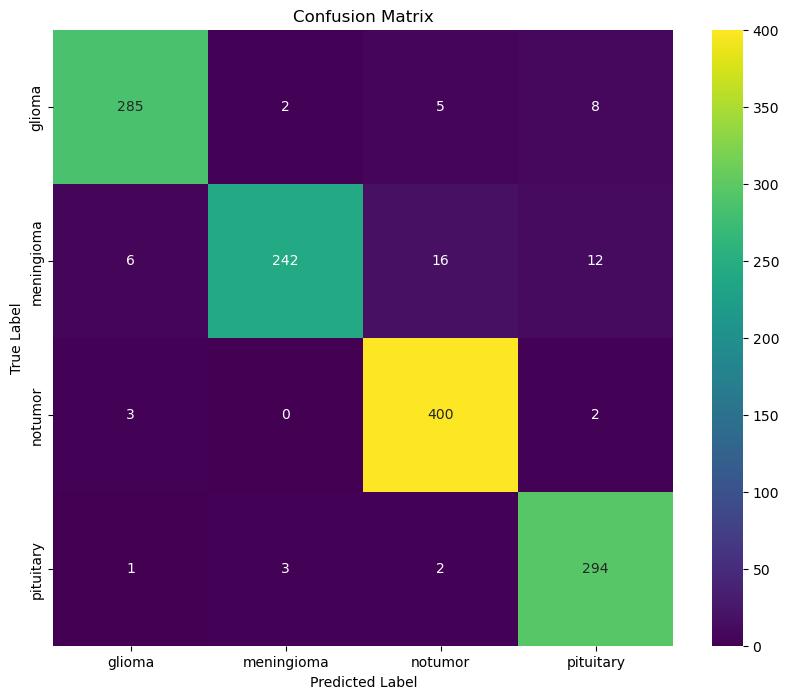

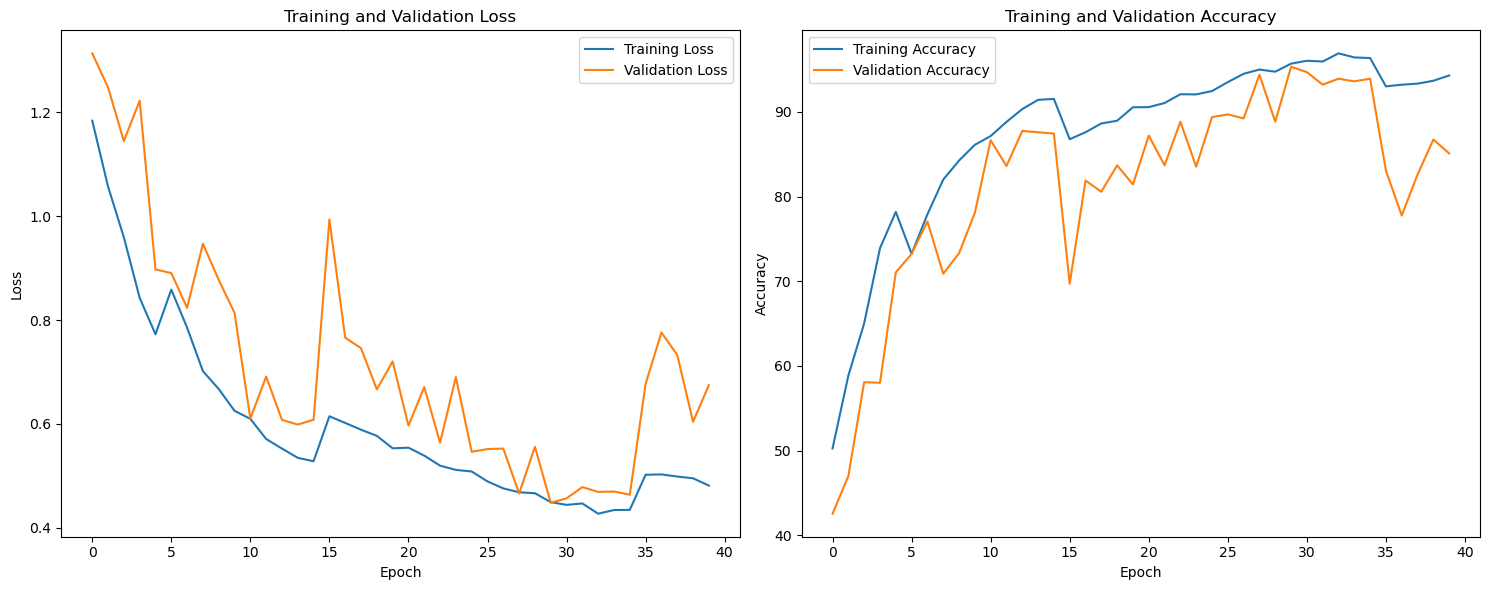

In [ ]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)

# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")

# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))

# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        label_idx = self.label_to_index[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Enhanced Data Augmentation with More Advanced Transformations
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((299, 299)),  # Use Inception-style input size
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.3),
        transforms.ToTensor(),  # Remove RandomErasing to resolve the error
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])

# Create balanced sampling function
def get_class_weights(dataset):
    class_counts = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] = class_counts.get(label, 0) + 1
    
    total_samples = len(dataset)
    class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
    
    return [class_weights[dataset[i][1]] for i in range(len(dataset))]

# DataLoader configuration
batch_size = 48
num_workers = 8

train_weights = get_class_weights(train_dataset)
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, pin_memory=True)

# Advanced Loss Functions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, inputs, targets):
        log_prob = F.log_softmax(inputs, dim=-1)
        loss = (1 - self.smoothing) * F.nll_loss(log_prob, targets) + \
               self.smoothing * (-log_prob.mean(dim=-1)).mean()
        return loss

# Squeeze-and-Excitation Layer
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Advanced Residual Block with Squeeze-and-Excitation
class AdvancedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(AdvancedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

# Advanced Architecture with More Sophisticated Residual Connections
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super(EnhancedCNN, self).__init__()
        
        # Initial Convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual Blocks with Varying Depths
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 4, stride=2)
        self.layer4 = self._make_layer(256, 512, 4, stride=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Advanced Classifier with Dropout and BatchNorm
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(AdvancedResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(AdvancedResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Enhanced Training Loop with Advanced Techniques
def train_and_evaluate(model, train_loader, test_loader, num_epochs=50, learning_rate=1e-3, 
                       weight_decay=1e-4, patience=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Advanced Loss Function (Label Smoothing Cross Entropy)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    
    # AdamW Optimizer with Higher Learning Rate
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay, amsgrad=True)
    
    # Cosine Annealing with Warm Restarts and Exponential Warmup
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-5
    )
    
    # Gradient Scaler for Mixed Precision Training
    scaler = GradScaler()

    history = {
        'loss': [], 'accuracy': [], 
        'val_loss': [], 'val_accuracy': [],
        'learning_rate': []
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Mixed Precision Training
            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Gradient Scaling
            scaler.scale(loss).backward()
            
            # Gradient Clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()

            # Learning Rate Scheduling
            scheduler.step(epoch + progress_bar.n / len(progress_bar))

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'Loss': f'{running_loss/total:.4f}', 
                'Accuracy': f'{100 * correct / total:.2f}%',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

        # Validation Phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Compute and store metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        epoch_val_loss = val_running_loss / len(test_loader)
        epoch_val_accuracy = 100 * val_correct / val_total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1}/{num_epochs} Training, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation, Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")

        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break

    # Final Evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds, all_labels = [], []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1

    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
                xticklabels=train_dataset.label_to_index.keys(), 
                yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

# Create Enhanced Model
model = EnhancedCNN()

# Train and Evaluate
model, history = train_and_evaluate(model, train_loader, test_loader)


#Code Version6

Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/ to data/testing/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/ to data/testing/notumor
Downloaded data from s3://sagemaker-studio-010526

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Starting Training...


Epoch 1/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 1/50 Training, Loss: 1.3166, Accuracy: 37.64%
Epoch 1/50 Validation, Loss: 1.6376, Accuracy: 44.34%


Epoch 2/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 2/50 Training, Loss: 1.2095, Accuracy: 49.20%
Epoch 2/50 Validation, Loss: 1.4678, Accuracy: 45.04%


Epoch 3/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 3/50 Training, Loss: 1.1078, Accuracy: 56.76%
Epoch 3/50 Validation, Loss: 1.0355, Accuracy: 60.58%


Epoch 4/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 4/50 Training, Loss: 1.0351, Accuracy: 61.44%
Epoch 4/50 Validation, Loss: 1.0194, Accuracy: 58.86%


Epoch 5/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 5/50 Training, Loss: 0.9904, Accuracy: 64.63%
Epoch 5/50 Validation, Loss: 1.0076, Accuracy: 61.05%


Epoch 6/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 6/50 Training, Loss: 1.0700, Accuracy: 59.57%
Epoch 6/50 Validation, Loss: 1.1544, Accuracy: 54.57%


Epoch 11/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 11/50 Training, Loss: 0.7483, Accuracy: 78.93%
Epoch 11/50 Validation, Loss: 0.6043, Accuracy: 86.81%


Epoch 12/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 12/50 Training, Loss: 0.7035, Accuracy: 81.19%
Epoch 12/50 Validation, Loss: 0.5769, Accuracy: 88.76%


Epoch 13/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 13/50 Training, Loss: 0.6790, Accuracy: 83.28%
Epoch 13/50 Validation, Loss: 0.5651, Accuracy: 89.54%


Epoch 14/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 14/50 Training, Loss: 0.6559, Accuracy: 84.05%
Epoch 14/50 Validation, Loss: 0.5472, Accuracy: 89.54%


Epoch 15/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 15/50 Training, Loss: 0.6448, Accuracy: 84.26%
Epoch 15/50 Validation, Loss: 0.5487, Accuracy: 89.77%


Epoch 16/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 16/50 Training, Loss: 0.7550, Accuracy: 79.36%
Epoch 16/50 Validation, Loss: 0.7009, Accuracy: 82.12%


Epoch 17/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 17/50 Training, Loss: 0.7293, Accuracy: 80.19%
Epoch 17/50 Validation, Loss: 0.6787, Accuracy: 82.20%


Epoch 18/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 18/50 Training, Loss: 0.7079, Accuracy: 80.88%
Epoch 18/50 Validation, Loss: 0.9760, Accuracy: 69.87%


Epoch 19/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 19/50 Training, Loss: 0.6844, Accuracy: 82.37%
Epoch 19/50 Validation, Loss: 0.5325, Accuracy: 90.87%


Epoch 20/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 20/50 Training, Loss: 0.6597, Accuracy: 83.82%
Epoch 20/50 Validation, Loss: 0.6488, Accuracy: 85.01%


Epoch 21/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 21/50 Training, Loss: 0.6532, Accuracy: 84.33%
Epoch 21/50 Validation, Loss: 0.7130, Accuracy: 80.17%


Epoch 22/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 22/50 Training, Loss: 0.6392, Accuracy: 84.91%
Epoch 22/50 Validation, Loss: 0.6567, Accuracy: 83.14%


Epoch 23/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 23/50 Training, Loss: 0.6221, Accuracy: 85.77%
Epoch 23/50 Validation, Loss: 0.7084, Accuracy: 81.81%


Epoch 24/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 24/50 Training, Loss: 0.6110, Accuracy: 86.68%
Epoch 24/50 Validation, Loss: 0.5482, Accuracy: 89.38%


Epoch 25/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 25/50 Training, Loss: 0.6017, Accuracy: 87.12%
Epoch 25/50 Validation, Loss: 0.5012, Accuracy: 92.19%


Epoch 26/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 26/50 Training, Loss: 0.5923, Accuracy: 87.80%
Epoch 26/50 Validation, Loss: 0.5243, Accuracy: 91.80%


Epoch 27/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 27/50 Training, Loss: 0.5789, Accuracy: 88.27%
Epoch 27/50 Validation, Loss: 0.4664, Accuracy: 94.30%


Epoch 28/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 28/50 Training, Loss: 0.5540, Accuracy: 89.54%
Epoch 28/50 Validation, Loss: 0.4817, Accuracy: 92.58%


Epoch 29/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 29/50 Training, Loss: 0.5466, Accuracy: 89.91%
Epoch 29/50 Validation, Loss: 0.4680, Accuracy: 94.46%


Epoch 30/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 30/50 Training, Loss: 0.5433, Accuracy: 90.04%
Epoch 30/50 Validation, Loss: 0.4764, Accuracy: 93.36%


Epoch 31/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 31/50 Training, Loss: 0.5412, Accuracy: 90.67%
Epoch 31/50 Validation, Loss: 0.4545, Accuracy: 95.39%


Epoch 32/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 32/50 Training, Loss: 0.5225, Accuracy: 91.13%
Epoch 32/50 Validation, Loss: 0.4402, Accuracy: 95.86%


Epoch 33/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 33/50 Training, Loss: 0.5335, Accuracy: 90.68%
Epoch 33/50 Validation, Loss: 0.4489, Accuracy: 95.32%


Epoch 34/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 34/50 Training, Loss: 0.5204, Accuracy: 91.72%
Epoch 34/50 Validation, Loss: 0.4337, Accuracy: 96.33%


Epoch 35/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 35/50 Training, Loss: 0.5232, Accuracy: 91.45%
Epoch 35/50 Validation, Loss: 0.4419, Accuracy: 95.94%


Epoch 36/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 36/50 Training, Loss: 0.5960, Accuracy: 87.46%
Epoch 36/50 Validation, Loss: 0.4803, Accuracy: 94.46%


Epoch 37/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 37/50 Training, Loss: 0.5816, Accuracy: 88.29%
Epoch 37/50 Validation, Loss: 0.5134, Accuracy: 91.33%


Epoch 38/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 38/50 Training, Loss: 0.5880, Accuracy: 88.02%
Epoch 38/50 Validation, Loss: 0.5903, Accuracy: 87.43%


Epoch 39/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 39/50 Training, Loss: 0.6053, Accuracy: 86.82%
Epoch 39/50 Validation, Loss: 0.5640, Accuracy: 89.15%


Epoch 40/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.06s/it]


Epoch 40/50 Training, Loss: 0.5941, Accuracy: 87.50%
Epoch 40/50 Validation, Loss: 0.4814, Accuracy: 93.68%


Epoch 41/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 41/50 Training, Loss: 0.5830, Accuracy: 88.14%
Epoch 41/50 Validation, Loss: 0.5513, Accuracy: 88.84%


Epoch 42/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 42/50 Training, Loss: 0.5635, Accuracy: 88.89%
Epoch 42/50 Validation, Loss: 0.4746, Accuracy: 93.68%


Epoch 43/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 43/50 Training, Loss: 0.5660, Accuracy: 89.09%
Epoch 43/50 Validation, Loss: 0.5383, Accuracy: 90.40%


Epoch 44/50 [Validation]: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 44/50 Training, Loss: 0.5630, Accuracy: 89.43%
Epoch 44/50 Validation, Loss: 0.5167, Accuracy: 91.57%
Early stopping triggered after 44 epochs!


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Accuracy for glioma: 0.9600
Accuracy for meningioma: 0.8949
Accuracy for notumor: 0.9901
Accuracy for pituitary: 0.9933

Confusion Matrix:
[[288   6   3   3]
 [  3 247  16  10]
 [  1   2 401   1]
 [  0   1   1 298]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.96      0.89      0.93       276
     notumor       0.95      0.99      0.97       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.96      1281
   macro avg       0.96      0.96      0.96      1281
weighted avg       0.96      0.96      0.96      1281



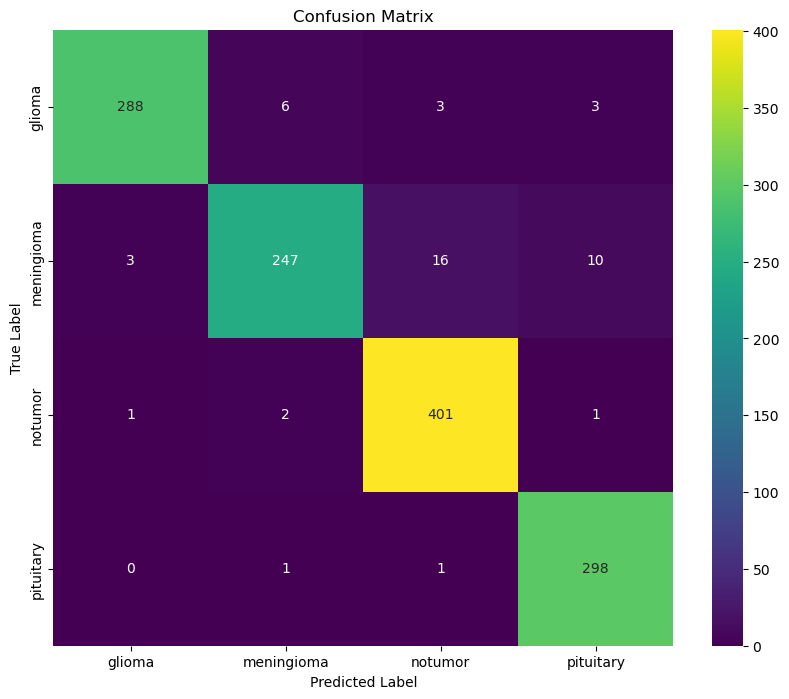

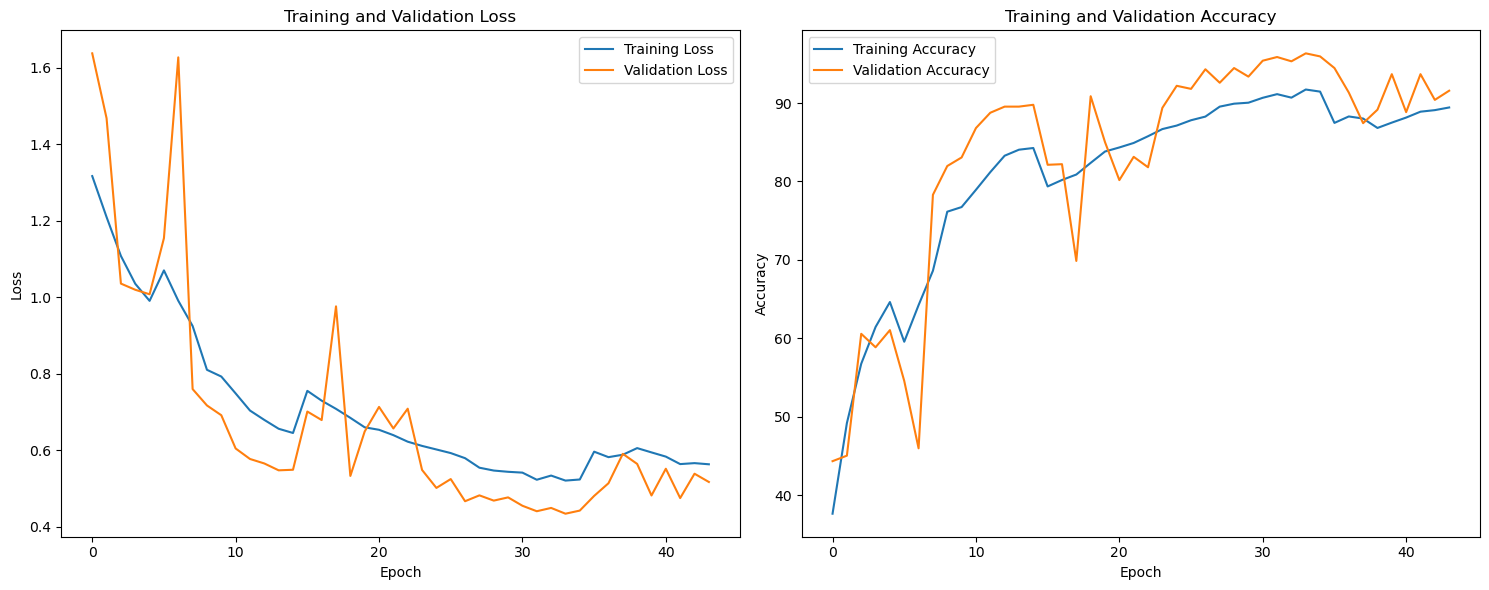

In [ ]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)

# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")

# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))

# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        label_idx = self.label_to_index[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Enhanced Data Augmentation with More Advanced Transformations
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((299, 299)),  # Use Inception-style input size
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.75, 1.33)), # Increased scale jitter
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(45),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05), # Reduced intensity
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.1), shear=10), # Increased scale jitter
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3), # reduced intensity
        transforms.TrivialAugmentWide(),  # Apply TrivialAugment for robust augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])

# Create balanced sampling function
def get_class_weights(dataset):
    class_counts = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] = class_counts.get(label, 0) + 1
    
    total_samples = len(dataset)
    class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
    
    return [class_weights[dataset[i][1]] for i in range(len(dataset))]

# DataLoader configuration
batch_size = 48
num_workers = 8

train_weights = get_class_weights(train_dataset)
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, pin_memory=True)

# Advanced Loss Functions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, inputs, targets):
        log_prob = F.log_softmax(inputs, dim=-1)
        loss = (1 - self.smoothing) * F.nll_loss(log_prob, targets) + \
               self.smoothing * (-log_prob.mean(dim=-1)).mean()
        return loss

# Squeeze-and-Excitation Layer
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(inplace=True),  # Changed ReLU to SiLU
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Advanced Residual Block with Squeeze-and-Excitation
class AdvancedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(AdvancedResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.SiLU(inplace=True)  # Changed ReLU to SiLU
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

# Advanced Architecture with More Sophisticated Residual Connections
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.3): # reduced dropout
        super(EnhancedCNN, self).__init__()
        
        # Initial Convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU(inplace=True), # Changed ReLU to SiLU
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual Blocks with Varying Depths
        self.layer1 = self._make_layer(64, 64, 3)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 4, stride=2)
        self.layer4 = self._make_layer(256, 512, 4, stride=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Advanced Classifier with Dropout and BatchNorm
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(inplace=True),  # Changed ReLU to SiLU
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(AdvancedResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(AdvancedResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Enhanced Training Loop with Advanced Techniques
def train_and_evaluate(model, train_loader, test_loader, num_epochs=50, learning_rate=1e-3, 
                       weight_decay=1e-4, patience=10, clipping_value=0.5): # reduced clipping
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Advanced Loss Function (Label Smoothing Cross Entropy)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    
    # AdamW Optimizer with Higher Learning Rate
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay, amsgrad=True)
    
    # Cosine Annealing with Warm Restarts and Exponential Warmup
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-5
    )

    scaler = GradScaler()

    history = {
        'loss': [], 'accuracy': [], 
        'val_loss': [], 'val_accuracy': [],
        'learning_rate': []
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            # Gradient Scaling and Clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clipping_value)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step(epoch + progress_bar.n / len(progress_bar))

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'Loss': f'{running_loss/total:.4f}', 
                'Accuracy': f'{100 * correct / total:.2f}%',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

        # Validation Phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        all_val_preds, all_val_labels = [], []  # Store predictions and labels for detailed analysis

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        # Compute and store metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        epoch_val_loss = val_running_loss / len(test_loader)
        epoch_val_accuracy = 100 * val_correct / val_total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1}/{num_epochs} Training, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation, Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")

        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break

    # Final Evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds, all_labels = [], []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1

    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", 
                xticklabels=train_dataset.label_to_index.keys(), 
                yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history

# Create Enhanced Model
model = EnhancedCNN()

# Train and Evaluate
model, history = train_and_evaluate(model, train_loader, test_loader)

#Code Version7

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/ to data/training/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/ to data/training/meningioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/ to data/training/notumor
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/ to data/training/pituitary
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/ to data/testing/glioma
Downloaded data from s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningiom

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Starting Training...


Epoch 1/40 [Validation]: 100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


Epoch 1/40 Training, Loss: 1.1627, Accuracy: 52.54%
Epoch 1/40 Validation, Loss: 2.7670, Accuracy: 37.16%


Epoch 2/40 [Validation]: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]


Epoch 2/40 Training, Loss: 1.0634, Accuracy: 58.05%
Epoch 2/40 Validation, Loss: 0.9479, Accuracy: 65.81%


Epoch 3/40 [Validation]: 100%|██████████| 21/21 [00:47<00:00,  2.28s/it]


Epoch 3/40 Training, Loss: 0.9599, Accuracy: 64.32%
Epoch 3/40 Validation, Loss: 0.9969, Accuracy: 63.08%


Epoch 4/40 [Validation]: 100%|██████████| 21/21 [00:47<00:00,  2.27s/it]


Epoch 4/40 Training, Loss: 0.8767, Accuracy: 69.58%
Epoch 4/40 Validation, Loss: 0.7898, Accuracy: 73.15%


Epoch 5/40 [Validation]: 100%|██████████| 21/21 [00:47<00:00,  2.28s/it]


Epoch 5/40 Training, Loss: 0.8229, Accuracy: 72.50%
Epoch 5/40 Validation, Loss: 0.7245, Accuracy: 77.52%


Epoch 6/40 [Validation]: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


Epoch 6/40 Training, Loss: 0.8728, Accuracy: 69.78%
Epoch 6/40 Validation, Loss: 1.0257, Accuracy: 63.31%


Epoch 7/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 7/40 Training, Loss: 0.8633, Accuracy: 70.37%
Epoch 7/40 Validation, Loss: 0.6992, Accuracy: 78.30%


Epoch 8/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.29s/it]


Epoch 8/40 Training, Loss: 0.7857, Accuracy: 74.55%
Epoch 8/40 Validation, Loss: 0.6867, Accuracy: 78.45%


Epoch 9/40 [Validation]: 100%|██████████| 21/21 [00:47<00:00,  2.24s/it]


Epoch 9/40 Training, Loss: 0.7200, Accuracy: 78.40%
Epoch 9/40 Validation, Loss: 0.7711, Accuracy: 73.61%


Epoch 10/40 [Validation]: 100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 10/40 Training, Loss: 0.6873, Accuracy: 80.11%
Epoch 10/40 Validation, Loss: 0.6984, Accuracy: 78.61%


Epoch 11/40 [Validation]: 100%|██████████| 21/21 [00:40<00:00,  1.92s/it]


Epoch 11/40 Training, Loss: 0.6381, Accuracy: 82.76%
Epoch 11/40 Validation, Loss: 0.5964, Accuracy: 84.39%


Epoch 12/40 [Validation]: 100%|██████████| 21/21 [00:40<00:00,  1.90s/it]


Epoch 12/40 Training, Loss: 0.6178, Accuracy: 84.21%
Epoch 12/40 Validation, Loss: 0.5510, Accuracy: 87.43%


Epoch 13/40 [Validation]: 100%|██████████| 21/21 [00:39<00:00,  1.88s/it]


Epoch 13/40 Training, Loss: 0.5908, Accuracy: 84.91%
Epoch 13/40 Validation, Loss: 0.5096, Accuracy: 89.38%


Epoch 14/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Epoch 14/40 Training, Loss: 0.5677, Accuracy: 86.36%
Epoch 14/40 Validation, Loss: 0.4796, Accuracy: 91.10%


Epoch 15/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Epoch 15/40 Training, Loss: 0.5600, Accuracy: 87.23%
Epoch 15/40 Validation, Loss: 0.4972, Accuracy: 89.62%


Epoch 16/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.33s/it]


Epoch 16/40 Training, Loss: 0.6664, Accuracy: 80.76%
Epoch 16/40 Validation, Loss: 0.6550, Accuracy: 84.00%


Epoch 17/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 17/40 Training, Loss: 0.6420, Accuracy: 82.46%
Epoch 17/40 Validation, Loss: 0.6156, Accuracy: 83.29%


Epoch 18/40 [Validation]: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it]


Epoch 18/40 Training, Loss: 0.6187, Accuracy: 83.80%
Epoch 18/40 Validation, Loss: 0.5499, Accuracy: 86.89%


Epoch 19/40 [Validation]: 100%|██████████| 21/21 [00:49<00:00,  2.34s/it]


Epoch 19/40 Training, Loss: 0.6164, Accuracy: 83.24%
Epoch 19/40 Validation, Loss: 0.5378, Accuracy: 87.82%


Epoch 20/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 20/40 Training, Loss: 0.5932, Accuracy: 85.44%
Epoch 20/40 Validation, Loss: 0.5692, Accuracy: 87.82%


Epoch 21/40 [Validation]: 100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Epoch 21/40 Training, Loss: 0.5736, Accuracy: 86.41%
Epoch 21/40 Validation, Loss: 0.5122, Accuracy: 89.77%
Early stopping triggered after 21 epochs!


100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Accuracy for glioma: 0.9033
Accuracy for meningioma: 0.7246
Accuracy for notumor: 0.9852
Accuracy for pituitary: 0.9900

Confusion Matrix:
[[271  21   5   3]
 [ 18 200  29  29]
 [  6   0 399   0]
 [  3   0   0 297]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.90      0.91       300
  meningioma       0.90      0.72      0.80       276
     notumor       0.92      0.99      0.95       405
   pituitary       0.90      0.99      0.94       300

    accuracy                           0.91      1281
   macro avg       0.91      0.90      0.90      1281
weighted avg       0.91      0.91      0.91      1281



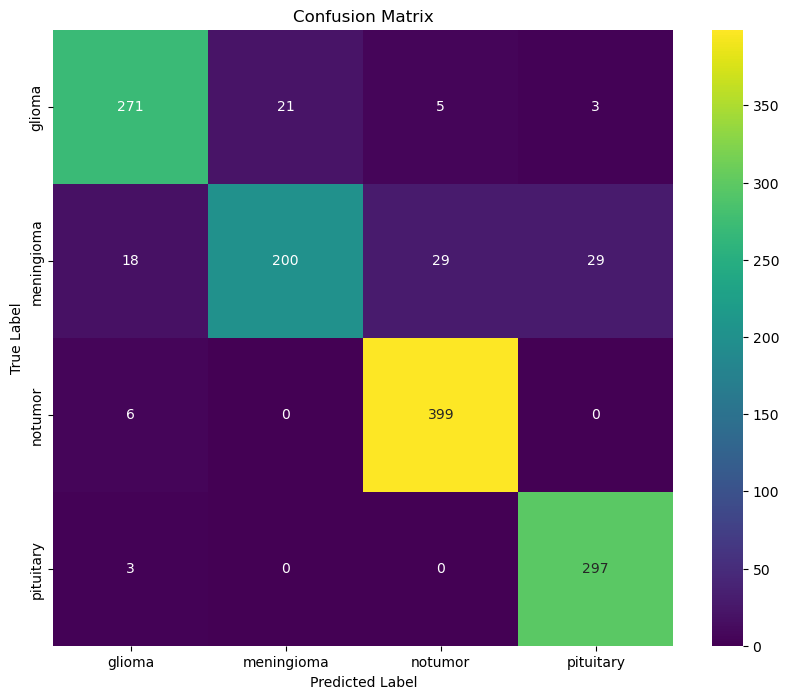

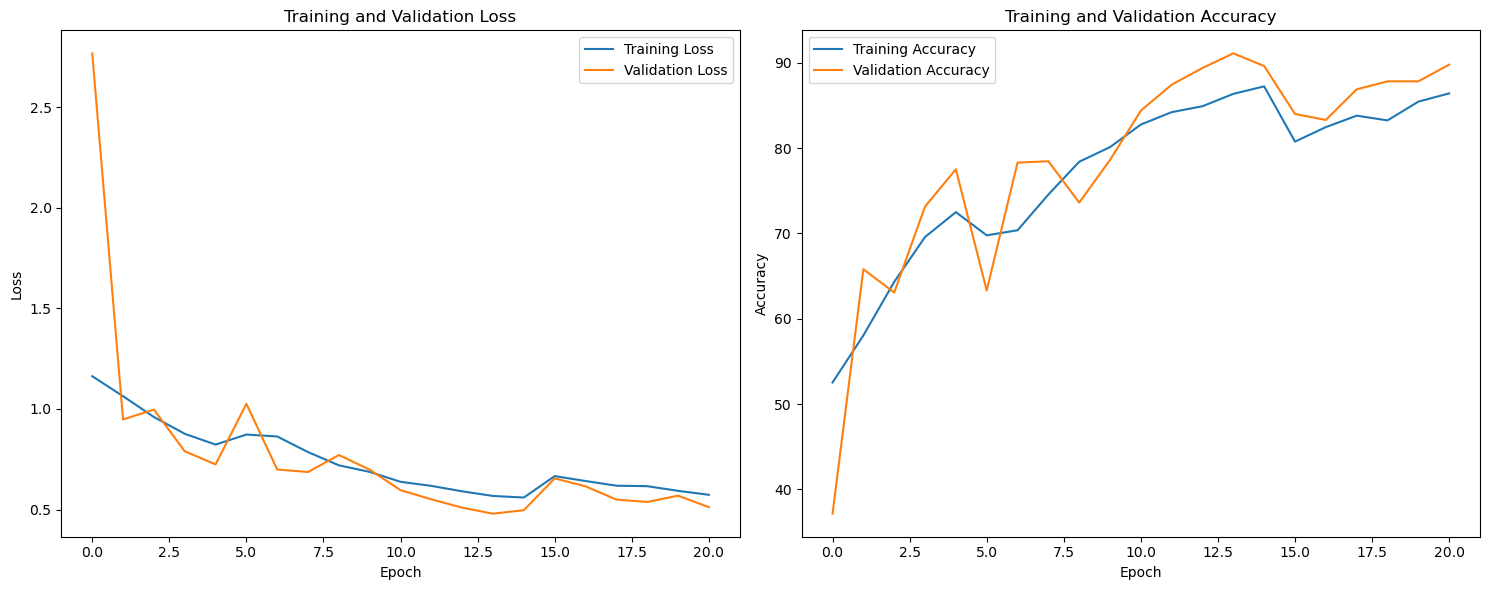

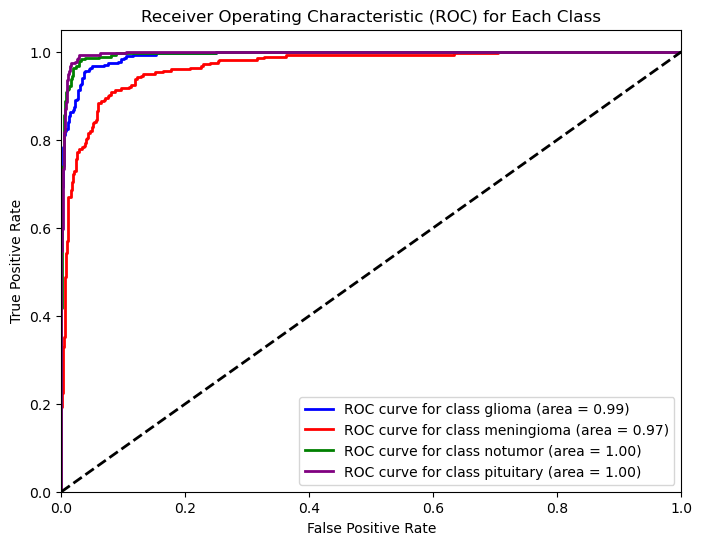

In [6]:
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

# 1. Define S3 bucket and prefixes
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name

# Define data locations in S3
training_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Training/pituitary/"
}

testing_data_s3 = {
    'glioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/glioma/",
    'meningioma': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/meningioma/",
    'notumor': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/notumor/",
    'pituitary': "s3://sagemaker-studio-010526272250-hsf94lgtf6i/Brain Tumor MRI Dataset/Testing/pituitary/"
}

# Local directory to download data (create if it doesn't exist)
local_data_dir = 'data'
if not os.path.exists(local_data_dir):
    os.makedirs(local_data_dir)

local_training_dir = os.path.join(local_data_dir, 'training')
local_testing_dir = os.path.join(local_data_dir, 'testing')
if not os.path.exists(local_training_dir):
    os.makedirs(local_training_dir)
if not os.path.exists(local_testing_dir):
    os.makedirs(local_testing_dir)

# 2. Download data from S3 to local
def download_data(s3_path, local_path):
    s3 = boto3.resource('s3')
    bucket_name = s3_path.split('/')[2]
    prefix = '/'.join(s3_path.split('/')[3:])

    bucket = s3.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=prefix):
        target = os.path.join(local_path, os.path.relpath(obj.key, prefix))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
    print(f"Downloaded data from {s3_path} to {local_path}")

# Download training data
for label, s3_path in training_data_s3.items():
    download_data(s3_path, os.path.join(local_training_dir, label))

# Download testing data
for label, s3_path in testing_data_s3.items():
    download_data(s3_path, os.path.join(local_testing_dir, label))

# 3. Data Preparation (Dataset and DataLoader)
class BrainTumorDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if not os.path.isdir(label_dir):
                continue

            for image_file in glob.glob(os.path.join(label_dir, '*.jpg')) + glob.glob(os.path.join(label_dir, '*.png')):
                self.image_paths.append(image_file)
                self.labels.append(label)

        self.label_to_index = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
        self.index_to_label = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        label_idx = self.label_to_index[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Enhanced Data Augmentation with More Advanced Transformations
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((256, 256)),  # Reduced Size for Efficiency
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(p=0.4), #Reduced
        transforms.RandomVerticalFlip(p=0.2),#Reduced
        transforms.RandomRotation(30), #Reduced
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.03), # Reduced intensity
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=8), # Reduced
        transforms.RandomPerspective(distortion_scale=0.1, p=0.2), # reduced intensity
        transforms.TrivialAugmentWide(),  # Apply TrivialAugment for robust augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize((256, 256)), #Reduced
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
train_dataset = BrainTumorDataset(data_dir=local_training_dir, transform=data_transforms['training'])
test_dataset = BrainTumorDataset(data_dir=local_testing_dir, transform=data_transforms['testing'])

# Create balanced sampling function
def get_class_weights(dataset):
    class_counts = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] = class_counts.get(label, 0) + 1
    
    total_samples = len(dataset)
    class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
    
    return [class_weights[dataset[i][1]] for i in range(len(dataset))]

# DataLoader configuration
batch_size = 64 # Increased batch size
num_workers = 4 #Reduced

train_weights = get_class_weights(train_dataset)
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                         num_workers=num_workers, pin_memory=True)

# Advanced Loss Functions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.08): #reduced smoothing
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, inputs, targets):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(inputs, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=targets.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# Squeeze-and-Excitation Layer
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.SiLU(inplace=True),  # Changed ReLU to SiLU
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Efficient Residual Block with Squeeze-and-Excitation
class EfficientResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(EfficientResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.SiLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Squeeze-and-Excitation

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Lightweight CNN Architecture
class LightWeightCNN(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.2):  # Reduced Dropout
        super(LightWeightCNN, self).__init__()

        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False), #Reduced Channels and kernel Size
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduced kernel Size
        )

        self.layer1 = self._make_layer(32, 64, 2, stride=1)  # Reduced blocks
        self.layer2 = self._make_layer(64, 128, 2, stride=2) # Reduced blocks
        self.layer3 = self._make_layer(128, 256, 2, stride=2) # Reduced blocks
        self.layer4 = self._make_layer(256, 512, 1, stride=2) # added one layer to extract high level features

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate), #Reduced
            nn.Linear(512, 256),   #Reduced Neurons
            nn.BatchNorm1d(256), #Reduced
            nn.SiLU(inplace=True),
            nn.Dropout(dropout_rate),#Reduced
            nn.Linear(256, num_classes) #Reduced
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(EfficientResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(EfficientResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Enhanced Training Loop with Advanced Techniques
def train_and_evaluate(model, train_loader, test_loader, train_dataset, num_epochs=40, learning_rate=8e-4,  # Reduced epochs and Learning rate
                       weight_decay=1e-5, patience=7, clipping_value=0.4): # Reduced clipping and patience
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Advanced Loss Function (Label Smoothing Cross Entropy)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.08) #Reduced

    # AdamW Optimizer with Higher Learning Rate
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                             weight_decay=weight_decay, amsgrad=True)

    # Cosine Annealing with Warm Restarts and Exponential Warmup
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-6  # Reduced eta_min
    )

    scaler = GradScaler()

    history = {
        'loss': [], 'accuracy': [],
        'val_loss': [], 'val_accuracy': [],
        'learning_rate': []
    }

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting Training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            # Gradient Scaling and Clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clipping_value)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step(epoch + progress_bar.n / len(progress_bar))

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({
                'Loss': f'{running_loss/total:.4f}',
                'Accuracy': f'{100 * correct / total:.2f}%',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })

        # Validation Phase
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        all_val_preds, all_val_labels = [], []  # Store predictions and labels for detailed analysis

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        # Compute and store metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        epoch_val_loss = val_running_loss / len(test_loader)
        epoch_val_accuracy = 100 * val_correct / val_total

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f"Epoch {epoch+1}/{num_epochs} Training, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        print(f"Epoch {epoch+1}/{num_epochs} Validation, Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_accuracy:.2f}%")

        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {epoch+1} epochs!")
                break

    # Final Evaluation
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds, all_labels = [], []
    correct_predictions = {label: 0 for label in train_dataset.label_to_index}
    total_predictions = {label: 0 for label in train_dataset.label_to_index}
    probabilities = [] #Store Probabilities

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())# Store Probalities

            for i in range(len(labels)):
                label = train_dataset.index_to_label[labels[i].item()]
                total_predictions[label] += 1
                if predicted[i] == labels[i]:
                    correct_predictions[label] += 1

    # Calculate per-class accuracy
    class_accuracies = {}
    for label in train_dataset.label_to_index:
        accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
        class_accuracies[label] = accuracy
        print(f"Accuracy for {label}: {accuracy:.4f}")

    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=train_dataset.label_to_index.keys())

    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(cr)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=train_dataset.label_to_index.keys(),
                yticklabels=train_dataset.label_to_index.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training history
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot AUC-ROC curves for each class
    n_classes = len(train_dataset.label_to_index)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Convert probabilities to a numpy array
    probabilities = np.array(probabilities)

    # Binarize labels
    binarized_labels = np.eye(n_classes)[all_labels]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple']  # Define colors for each class
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve for class {train_dataset.index_to_label[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Each Class')
    plt.legend(loc="lower right")
    plt.show()


    return model, history

# Create Enhanced Model
model = LightWeightCNN()

# Train and Evaluate
model, history = train_and_evaluate(model, train_loader, test_loader, train_dataset)